In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim 
import torch.nn as nn 


print("GPU avaviable: {}".format (torch.cuda.is_available()))


GPU avaviable: True


In [2]:
#Transform to a Pytorch tensors and the normalize our values between -1 and +1
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5, ))])

In [3]:
#Load our Training Data and specify what transform to use when loading 
trainset = torchvision.datasets.MNIST('mnist',
                                      train=True,
                                      download=True,
                                      transform=transform)

#Load our TEST data and specify what transform to use when loading 
testset = torchvision.datasets.MNIST('mnist',
                                     train=False,
                                     download=True,
                                     transform=transform)

In [4]:
print(trainset.data[5])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  13,  25, 100, 122,   7,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [7]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt

#Define our imshow function

def imgshow(title="", image=None, size= 5):
    w, h =image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size*aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

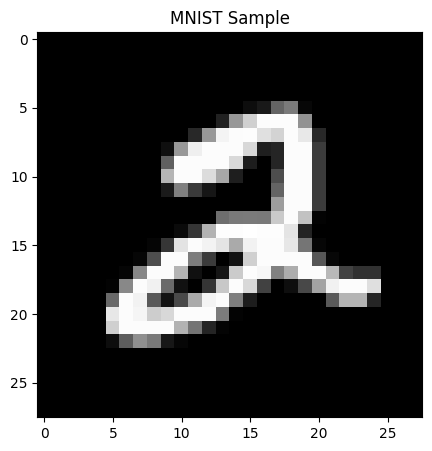

In [8]:
#convert image to a numpy array
image = trainset.data[5].numpy()
imgshow("MNIST Sample", image)

In [9]:
import torch.utils
import torch.utils.data


trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=0)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=128,
                                         shuffle=False,
                                         num_workers=0)


In [10]:
dataiter = iter(trainloader)
import numpy
images, labels = dataiter.__next__()
print(images.shape)
print(labels.shape)


torch.Size([128, 1, 28, 28])
torch.Size([128])


In [11]:
import torch.nn.functional as F 

class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 *12*12, 128)
        self.fc2 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        x =F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x 
    
net = Net()
net.to(device="cuda")
    

    

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
import torch

# Define your training loop
epochs = 3  # Correct the variable name

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
    print(f'Starting epoch: {epoch + 1}....')

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device="cuda")
        labels = labels.to(device="cuda")

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 49:
            correct = 0
            total = 0

            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    images = images.to(device="cuda")
                    labels = labels.to(device="cuda")

                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            epoch_num = epoch + 1
            actual_loss = running_loss / 50
            print(f'Epoch: {epoch_num}, Mini-Batch Completed: {i + 1}, Loss: {actual_loss:.3f}, Test Accuracy: {accuracy:.3f}')
            running_loss = 0.0

            epoch_log.append(epoch_num)
            loss_log.append(actual_loss)
            accuracy_log.append(accuracy)

    print('Finished Training')

# Note: The indentation of the final print statement is fixed.


Starting epoch: 1....
Epoch: 1, Mini-Batch Completed: 50, Loss: 0.373, Test Accuracy: 89.800
Epoch: 1, Mini-Batch Completed: 100, Loss: 0.353, Test Accuracy: 89.970
Epoch: 1, Mini-Batch Completed: 150, Loss: 0.335, Test Accuracy: 89.600
Epoch: 1, Mini-Batch Completed: 200, Loss: 0.356, Test Accuracy: 90.750
Epoch: 1, Mini-Batch Completed: 250, Loss: 0.346, Test Accuracy: 90.780
Epoch: 1, Mini-Batch Completed: 300, Loss: 0.330, Test Accuracy: 90.800
Epoch: 1, Mini-Batch Completed: 350, Loss: 0.316, Test Accuracy: 91.260
Epoch: 1, Mini-Batch Completed: 400, Loss: 0.287, Test Accuracy: 91.020
Epoch: 1, Mini-Batch Completed: 450, Loss: 0.322, Test Accuracy: 91.110
Finished Training
Starting epoch: 2....
Epoch: 2, Mini-Batch Completed: 50, Loss: 0.287, Test Accuracy: 92.500
Epoch: 2, Mini-Batch Completed: 100, Loss: 0.286, Test Accuracy: 92.580
Epoch: 2, Mini-Batch Completed: 150, Loss: 0.271, Test Accuracy: 92.350
Epoch: 2, Mini-Batch Completed: 200, Loss: 0.264, Test Accuracy: 92.960
Epoc

In [21]:
path = "mnist_cnn_net.pth"
torch.save(net.state_dict(), path)



In [22]:
net = Net()
net.to(device="cuda")

net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [23]:
test_iter = iter(testloader)
images, labels = test_iter.__next__()
images = images.to(device="cuda")
labels = labels.to(device= "cuda")
outputs = net(images)

predicted = torch.max(outputs , 1)

print('Predicted: ', ''.join('%ls' % predicted[j].cpu().numpy() for j in range(128)))


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.